## 📘 Machine Learning Optimization Project: K-Subspace Median via Convex Relaxation

This notebook provides an interactive implementation of the algorithm from  
**"An Efficient Approximation Algorithm for the k-Subspace Median Problem"**  
by Daniel Greenhut and Dan Feldman, University of Haifa.

It demonstrates how to approximate the **k-subspace median (KSM)**  
using a **convex relaxation (RL-KSM)** followed by **spectral rounding**.

> 📄 For full project description, context, and credits – see the [README](../README.md).

### Project Summary

This notebook demonstrates the algorithm proposed in  
*"An Efficient Approximation Algorithm for the k-Subspace Median Problem"*  
by Daniel Greenhut and Dan Feldman.

It integrates:
- A full implementation of **RL-KSM** using CVXPY (SDP + SOCP)
- A spectral rounding step matching the paper's theoretical guarantees
- Experiments on synthetic and real data comparing KSM with PCA and L1PCA
- Visualizations, error analysis, and statistical evaluation

> 💡 For details on implementation achievements, challenges, and open questions,  
> please refer to the [README](../README.md#-project-summary-goal-achievements-challenges).

### Acknowledgements

This notebook is based on the algorithm introduced in  
*"An Efficient Approximation Algorithm for the k-Subspace Median Problem"*  
by Daniel Greenhut and Dan Feldman, Robotics & Big Data Labs, University of Haifa.

> For full credits, external tools, and references — see the [main README](../README.md).


## 🧠 Code Structure and Key Functions

The notebook follows the KSM pipeline from theory to implementation:

1. **Problem Setup & Motivation**
   - Brief intro to the k-subspace median and PCA limitations.

2. **RL-KSM Relaxation**
   - `solve_rl_ksm(points, k)` implements the convex relaxation via CVXPY (SDP + SOCP)

3. **Spectral Rounding**
   - `ksm_exact(points, k)` performs eigendecomposition and ζ-based rounding to produce a projection matrix

4. **Synthetic 2D Demonstration**
   - Visualizes PCA, L1PCA, and KSM directions on clean and noisy data  
   - Matches the intuition of Figure 3 from the paper

5. **Projection Error Evaluation**
   - `projection_error(points, projection_matrix)` computes ℓ₂ reconstruction loss  
   - `run_subspace_comparison(...)` runs repeated comparisons on data subsets

6. **Result Analysis**
   - `compute_comparison_stats(...)` summarizes median/mean/win-rate  
   - Histograms and tables visualize KSM vs PCA/L1PCA ratios

7. **Real Data Pipeline**
   - Uses UCI Wine dataset  
   - Projects data to lower-dimensional subspaces with KSM, PCA, L1PCA  
   - Reports performance over 100+ subsets

> All utility functions are defined in `ksm_approx_notebook.py` for reuse.

### Step 1: Convex Relaxation (RL-KSM)

`solve_rl_ksm(points, k, weights=None)`

This function solves the **convex relaxation of the k-subspace median problem**,  
as described in Problem (2) of the paper.

It formulates a convex optimization problem using:
- **Semidefinite programming (SDP)** constraints: `X ≽ 0`,
                                                   `X ≼ I`,
                                                   `trace(X) = d - k`
                                                   
- **Second-order cone (SOCP)** constraints: `‖X·pᵢ‖₂ ≤ yᵢ` for each point

The function returns a relaxed projection matrix `X* ∈ ℝ^{d×d}`, which is used in the rounding step.

> Solved via `cvxpy` using either **MOSEK** (recommended) or **SCS** (fallback).
> See [README](../README.md) for installation and license instructions.


In [1]:
# Install required optimization packages (run once)
#!pip install mosek
#!pip install cvxpy
#!pip install cvxpy[mosek]

In [2]:
import os
import cvxpy as cp
# Set MOSEK license path (assumes the file is in the same folder as the notebook)
os.environ['MOSEKLM_LICENSE_FILE'] = "mosek.lic"

# Verify installed solvers
print("Available solvers:", cp.installed_solvers())

Available solvers: ['CLARABEL', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [3]:
import numpy as np

def solve_rl_ksm(points, k=1, weights=None):
    """
    Solve the convex relaxation of the k-subspace median problem (RL-KSM),
    using semidefinite programming (SDP) and second-order cone constraints (SOCP).

    Parameters
    ----------
    points : np.ndarray of shape (n, d)
        Data matrix with n points in d-dimensional space.
    k : int
        Subspace dimension to exclude. The method retains a (d−k)-dimensional subspace.
    weights : np.ndarray of shape (n,), optional
        Non-negative weights for each point. If None, uniform weights are used.

    Returns
    -------
    X_opt : np.ndarray of shape (d, d)
        Symmetric relaxed projection matrix X* satisfying PSD and trace constraints.

    Example
    -------
    >>> points = np.random.randn(100, 3)
    >>> X_star = solve_rl_ksm(points, k=1)
    >>> np.allclose(X_star, X_star.T)  # Symmetry check
    True
    """
    n, d = points.shape

    # Set uniform weights if none provided
    if weights is None:
        weights = np.ones(n) / n
    else:
        weights = np.asarray(weights, dtype=np.float64)

    # Define optimization variables
    X = cp.Variable((d, d), symmetric=True)
    y = cp.Variable(n)

    # Define constraints
    constraints = [
        X >> 0,                  # Positive semidefinite
        X << np.eye(d),          # Eigenvalues ≤ 1
        cp.trace(X) == d - k     # Controls retained subspace rank
    ]
    for i in range(n):
        constraints.append(cp.norm(X @ points[i], 2) <= y[i])  # SOCP constraint

    # Define objective: weighted sum of projected norms
    objective = cp.Minimize(weights @ y)

    # Solve the optimization problem
    prob = cp.Problem(objective, constraints)
    try:
        prob.solve(solver=cp.MOSEK, verbose=False)
    except:
        prob.solve(solver=cp.SCS, verbose=False)

    return X.value

### Step 2: Spectral Rounding (KSM-APPROX)

`ksm_exact(points, k, weights=None)`

This function implements **Algorithm 1: KSM-APPROX** from the paper,  
producing a robust projection matrix via convex relaxation + rounding.

It performs the following steps:

1. **Convex Relaxation**  
   Solves RL-KSM to obtain the relaxed matrix `X*`

2. **Eigen-Decomposition**  
   Computes eigenvalues and eigenvectors of `X*`

3. **Influence Scoring**  
   Measures how much each eigen-direction contributes to the data (via ℓ₂ projections)

4. **Direction Selection**  
   Retains the top `d−k` directions with highest influence (i.e., selects ζ ∈ {0,1}ᵈ)

5. **Projection Matrix Construction**  
   Builds the final rank-`d−k` projection matrix:  
   $$
   E = V \cdot \text{diag}(ζ) \cdot V^T
   $$

This rounded matrix `E` is then used to project new points in downstream analysis.


In [4]:
def ksm_exact(points, k=1, weights=None):

    """
    Implements KSM-APPROXIMATION (Algorithm 1 (KSM-APPROX) from the paper),
    Approximates the k-subspace median via convex relaxation and spectral rounding.

    Parameters:
    -----------
    points : ndarray of shape (n, d)
        Input data points (in ℝ^d).
    k : int
        Number of dimensions to preserve in the subspace.
    weights : np.ndarray of shape (n,), optional
        Weights for each point. Defaults to uniform.

    Returns:
    --------
    E : np.ndarray of shape (d, d)
        Projection matrix of rank d−k (approximating the robust subspace).
    V : np.ndarray of shape (d, d)
        Eigenvector matrix from spectral decomposition of X*.
    ζ : np.ndarray of shape (d,)
        Binary vector indicating which directions are preserved (ζ_j = 0) or discarded (ζ_j = 1)
        (indicating preserved (0) and removed (1) dimensions).

    """

    n, d = points.shape
    if weights is None:
        weights = np.ones(n) / n  # Use uniform weights if none provided

    # Step 1: Solve the convex relaxation (RL-KSM)
    # Returns X* ∈ ℝ^{d×d} that approximates projection onto (d−k)-dim subspace
    X_star = solve_rl_ksm(points, k, weights)

    # Step 2: Spectral decomposition of X*
      # X* = V D Vᵀ where:
      # V contains eigenvectors as columns (NumPy convention)
      # D is diagonal with eigenvalues in [0,1]
        # Note:
        # The paper writes X* = Vᵗ D V, which assumes V contains the eigenvectors as rows.
        # In NumPy, V has eigenvectors as columns, so we use X* = V D Vᵗ — these are equivalent.
    eigvals, V = np.linalg.eigh(X_star)

    # Step 3: Rotate input points into eigenbasis (V)
      # Each point p_i is rotated into the V-coordinate system by: v_i = Vᵗ p_i
      # Note: Since V is orthogonal, Vᵗ = V⁻¹ = V.T, so we can compute V @ p.T and transpose.
    v_proj = (V @ points.T).T  # Shape (n, d)

    # Step 4: Compute q_j = ∑ w_i · |v_ij| (weighted L1 influence of each direction)
      # Measures how much each eigen-direction contributes in the rotated space.
    q = np.sum(weights[:, None] * np.abs(v_proj), axis=0)  # Shape (d,)

    # Step 5: Select d−k least-influential directions (smallest q_j)
      # These directions will be zeroed out in the projection.
    ζ = np.ones(d)              # Start with ζ_j = 1 for all j
    Ind = np.argsort(q)[:d - k] # Indices of d−k smallest q_j
    ζ[Ind] = 0                  # Set ζ_j = 0 for preserved directions (they remain active)

    # Step 6: Construct projection matrix E = V diag(ζ) Vᵀ
      # Projects onto the orthogonal complement of the selected eigen-directions
      #  ζ_j = 1 means we discard that direction (project away from it).
    E = V @ np.diag(ζ) @ V.T

    return E, V, ζ

### 🔍 Visual Demo: KSM-APPROX on Synthetic Data (ℝ²)

We demonstrate **Algorithm 1 (KSM-APPROX)** on a synthetic 2D dataset,  
where points are distributed along the line `y = 0.5x` with Gaussian noise.

This visual setup replicates **Figure 3** from the paper and shows how KSM performs robust subspace approximation in the presence of noise.

The steps include:

- **(a)** Input points in ℝ²  
- **(b)** Rotation into eigenbasis `V` of the relaxed projection matrix `X*`  
- **(c)** Masking least-influential directions via binary vector `ζ`  
- **(d)** Reconstructing the projected points in the original space

Together, these steps show how the algorithm uses spectral structure and ℓ₂ energy to isolate meaningful directions.


> **Note on Projection Matrix Construction**  
> The projection matrix is built as:  
> $$
E = V \cdot \text{diag}(\zeta) \cdot V^\top
$$
> - In NumPy, `np.linalg.eigh(X*)` returns `V` with **eigenvectors as columns**.  
> - So projection is done as: `projected = points @ V @ diag(ζ) @ V.T`
> - This preserves the dominant `d−k` directions while nullifying the rest.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh

# Generate synthetic 2D points along a line with Gaussian noise
np.random.seed(0)
n = 200
x = np.linspace(-10, 10, n)
y = 0.5 * x + np.random.normal(0, 2, n)  # Line with noise

points = np.vstack((x, y)).T  # Shape (n, 2)
points.shape

(200, 2)

In [6]:
# Apply the KSM-APPROX algorithm
E, V, ζ = ksm_exact(points, k=1)
print(E, V, ζ)

# Get index of preserved direction (ζ_j = 0)
preserved_idx = int(np.argmin(ζ))

# Reorder the columns of V so that the preserved direction is in the first column
V_reordered = V.copy()
if preserved_idx != 0:
    V_reordered[:, [0, preserved_idx]] = V_reordered[:, [preserved_idx, 0]]

# (b) Rotate the original points into the reordered eigenbasis
# This transforms the data into the coordinate system defined by Vᵗ
rotated_points = points @ V_reordered

# (c) Project the rotated points by zeroing out the discarded directions
# Since ζ=1 means 'discard', we flip ζ to get a mask of preserved axes (1 - ζ)
ζ_proj = 1 - ζ
projected = rotated_points * ζ_proj

# (d) Rotate the projected points back to the original space
# This reconstructs the approximation in the original coordinate system
reconstructed = projected @ V_reordered.T

[[0.78025141 0.41407626]
 [0.41407626 0.21974859]] [[-0.88331841 -0.4687735 ]
 [-0.4687735   0.88331841]] [1. 0.]


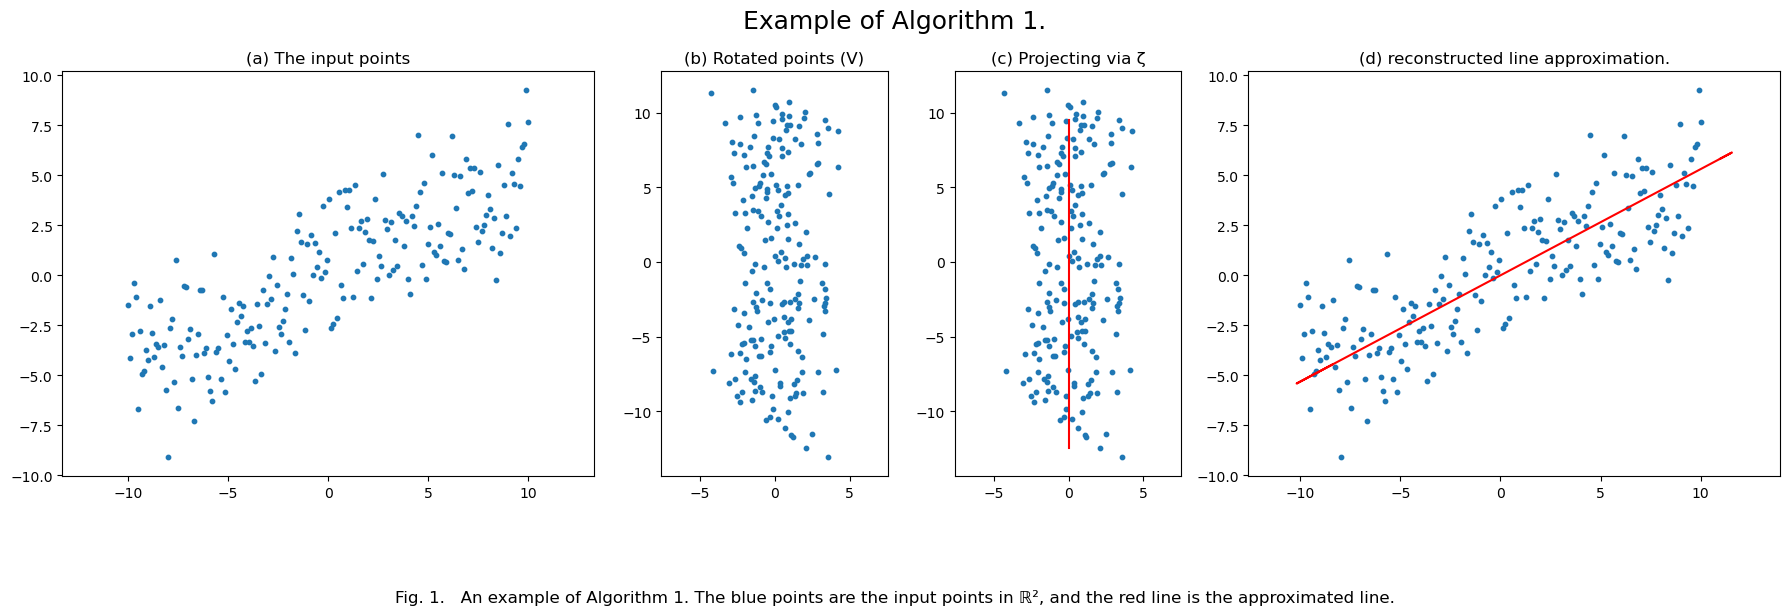

In [7]:
# Visualization to illustrate the key steps of the KSM-APPROX algorithm (Figure 3 from the paper)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

#Compute the X-range (width) of each subplot
x_ranges = [
    np.ptp(points[:, 0]),           # (a) Original points
    np.ptp(rotated_points[:, 0]),   # (b) Rotated points
    np.ptp(rotated_points[:, 0]),   # (c) Projected points
    np.ptp(points[:, 0])            # (d) Reconstructed approximation
]

# Create layout with GridSpec (2 rows: one for plots, one for captions)
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 4, width_ratios=x_ranges, height_ratios=[6, 1])

#(a) Plot of original input points
ax0 = fig.add_subplot(gs[0])
ax0.scatter(points[:, 0], points[:, 1], s=10)
ax0.set_title("(a) The input points")
ax0.axis("equal")

#(b) Plot of Rotated points (V)
ax1 = fig.add_subplot(gs[1])
ax1.scatter(rotated_points[:, 0], rotated_points[:, 1], s=10)
ax1.set_title("(b) Rotated points (V)")
ax1.axis("equal")

# (c) Plot of projected points (after masking with ζ)
ax2 = fig.add_subplot(gs[2])
ax2.scatter(rotated_points[:, 0], rotated_points[:, 1], s=10)
x0, y0 = projected[0]
x1, y1 = projected[-1]
ax2.add_line(Line2D([x0, x1], [y0, y1], color='red'))
ax2.set_title("(c) Projecting via ζ")
ax2.axis("equal")

#(d) Plot of final approximation in original space
ax3 = fig.add_subplot(gs[3])
ax3.scatter(points[:, 0], points[:, 1], s=10)
ax3.plot(reconstructed[:, 0], reconstructed[:, 1], 'r')
ax3.set_title("(d) reconstructed line approximation.")
ax3.axis("equal")

# Final layout adjustment
fig.suptitle("Example of Algorithm 1.",fontsize=18)
fig.text(0.5, 0,
         "Fig. 1.   An example of Algorithm 1. The blue points are the input points in ℝ², and the red line is the approximated line.",
         ha="center", va="center", fontsize=12)

plt.tight_layout()
plt.show()

## 🧪 Robustness to Outliers – Synthetic Test (ℝ²)

To assess the robustness of KSM, we replicate **Figure 1 from the paper**,  
comparing **KSM** and **PCA** on a noisy dataset with outliers.

### Experimental Setup:

- **Inliers**: 200 points along the line `y = 0.5x`, with Gaussian noise  
- **Outliers**: 10 points sampled far from the main distribution  
- **Goal**: Recover a meaningful 1D subspace despite the presence of outliers

We apply:
- **PCA**: standard ℓ₂ subspace using squared-error minimization  
- **KSM**: using RL-KSM + spectral rounding to minimize ℓ₂ distances (not squared)

We visualize the estimated subspaces (lines) overlaid on the full dataset.

---

> **Note on Visualization**  
> The projection matrix `E = V · diag(ζ) · Vᵀ` discards certain directions.  
> For visual comparison, we extract the direction(s) corresponding to `ζⱼ = 1` —  
> these span the dominant subspace identified by KSM.

This experiment highlights KSM’s improved stability under extreme outlier noise.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define Inliers
  # Use the previously generated 2D points lying approximately along a line
"""
  # Generate synthetic 2D points along a line with Gaussian noise
  np.random.seed(0)
  n = 200
  x = np.linspace(-10, 10, n)
  y = 0.5 * x + np.random.normal(0, 2, n)  # Line with noise
  points = np.vstack((x, y)).T  # Shape (n, 2)
"""
inliers = points

# Step 2: Generate Outliers
  # Add random points far from the inlier structure to test robustness
np.random.seed(0)  # For reproducibility
n_out = 10
x_out = np.random.uniform(-10, 10, n_out)
y_out = np.random.uniform(-40, 40, n_out)
outliers = np.column_stack((x_out, y_out))

# Step 3: Combine Inliers and Outliers
  # Merge both into a full dataset and assign uniform weights
full_points = np.vstack((inliers, outliers))  # Shape: (n + n_out, 2)
w = np.ones(full_points.shape[0]) / full_points.shape[0]  # Normalize weights

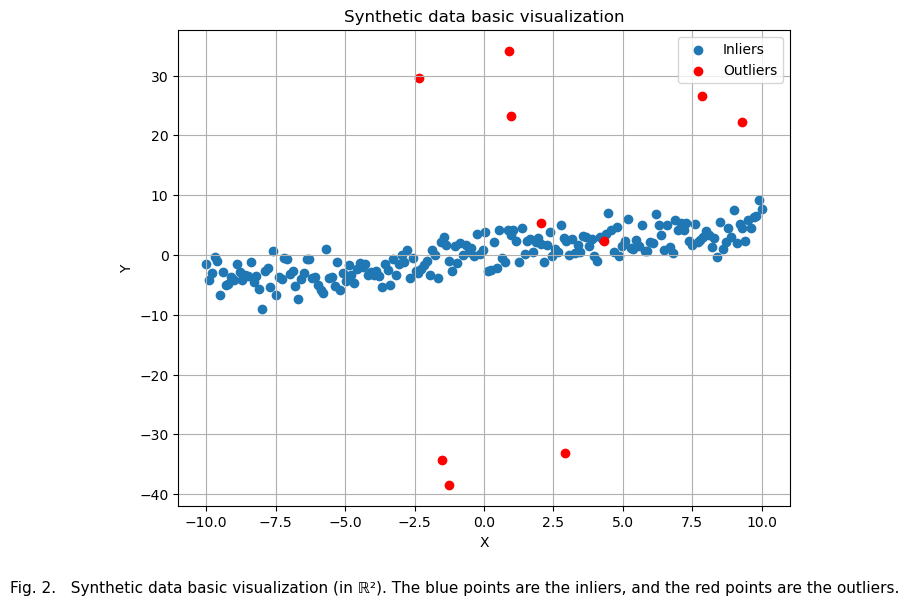

In [9]:
# Basic visualization
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(inliers[:, 0], inliers[:, 1], label="Inliers")
ax.scatter(outliers[:, 0], outliers[:, 1], label="Outliers", color="red")
ax.set_title("Synthetic data basic visualization")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
ax.legend()
fig.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for caption

# Caption
fig.text(0.5, 0.01,
         "Fig. 2.   Synthetic data basic visualization (in ℝ²). The blue points are the inliers, and the red points are the outliers.",
         ha="center", va="center", fontsize=11)

plt.show()

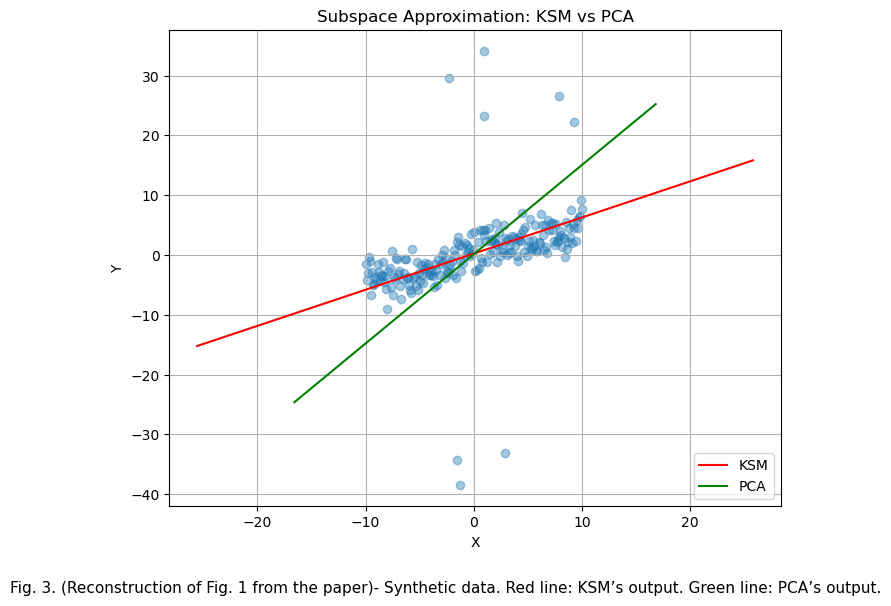

In [10]:
from sklearn.decomposition import PCA
# Define helper functions
  # Direction extraction function

def extract_subspace_directions(V, ζ):
    """
    Extracts preserved eigen-directions (columns of V) according to binary mask ζ.

    Parameters:
    -----------
    V : np.ndarray of shape (d, d)
        Eigenvector matrix from eigendecomposition.
    ζ : np.ndarray of shape (d,)
        Binary vector (0 = preserved, 1 = discarded).

    Returns:
    --------
    preserved_directions : np.ndarray of shape (d, k)
        The columns in V corresponding to ζ==0.

    """
    assert V.shape[0] == V.shape[1], "V must be a square matrix"
    assert ζ.shape[0] == V.shape[1], "ζ must match the number of columns in V"
    assert set(np.unique(ζ)).issubset({0, 1}), "ζ must be binary"

    return V[:, ζ == 1] # Select directions where ζ == 1

def subspace_line(direction, mean, scale=30):
    """
    Computes the endpoints of a 2D line segment that represents the estimated 1D subspace.

    The segment is centered at the mean point and extends in both directions
    along the given direction vector. This is used to visualize the output
    subspace from PCA or KSM in ℝ² when k=1.

    Parameters:
    -----------
    direction : np.ndarray of shape (2,)
        Direction vector for the subspace (must be normalized or will be).
    mean : np.ndarray of shape (2,)
        The point through which the line passes (typically the mean of the data).
    scale : float, optional
        Controls the length of the line segment (default is 30 units in each direction).

    Returns:
    --------
    line_points : np.ndarray of shape (2, 2)
        Two endpoints of the line segment for plotting.
    """
    direction = direction / np.linalg.norm(direction)
    return np.array([mean - scale * direction, mean + scale * direction])

# Apply the KSM-APPROX algorithm
E, V, ζ = ksm_exact(full_points, k=1, weights=w)
preserved = extract_subspace_directions(V, ζ)
dir_ksm = preserved[:, 0]

mean_ksm = np.mean(full_points, axis=0)
centered_points = full_points - mean_ksm
projected_ksm = (E @ centered_points.T).T + mean_ksm

# Apply PCA
pca = PCA(n_components=1)
pca.fit(full_points)
dir_pca = pca.components_[0]
mean_pca = pca.mean_

centered_pca = full_points - mean_pca
proj_pca_scalar = centered_pca @ dir_pca
projected_pca = np.outer(proj_pca_scalar, dir_pca) + mean_pca

# Visualization
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(full_points[:, 0], full_points[:, 1], alpha=0.4)

  # Compute subspace lines for both algorithms
line_ksm = subspace_line(dir_ksm, mean_ksm)
line_pca = subspace_line(dir_pca, mean_pca)

ax.plot(line_ksm[:, 0], line_ksm[:, 1], color="red", label="KSM")
ax.plot(line_pca[:, 0], line_pca[:, 1], color="green", label="PCA")

ax.set_title("Subspace Approximation: KSM vs PCA")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
ax.legend(loc="lower right")
fig.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for caption

  # Caption
fig.text(0.5, 0.01,
         "Fig. 3. (Reconstruction of Fig. 1 from the paper)- Synthetic data. "
         "Red line: KSM’s output. Green line: PCA’s output.",
         ha="center", va="center", fontsize=11)

plt.show()

## 📊 Subspace Comparison: KSM vs PCA and L1PCA

We compare the quality of subspace approximation using three methods:

- **KSM** – Algorithm 1 (RL-KSM + rounding)
- **PCA** – standard ℓ₂-based dimensionality reduction
- **L1PCA** – ℓ₁-norm principal component analysis (robust to outliers)

### Evaluation Metric:
We use **cumulative projection error** for each method,  
defined as the sum of ℓ₂ distances between the original points and their projections.

This experiment replicates **Figure 6** from the paper,  
where the performance is summarized by the ratios:

$$
\text{KSM Error} / \text{PCA Error}, \quad \text{KSM Error} / \text{L1PCA Error}
$$

The comparison is repeated over many random subsets of the dataset (e.g., 100 trials),  
and results are reported as **histograms** and **summary statistics**.

---

> ℓ₁-PCA implementation follows the method in:  
> *“Optimal algorithms for ℓ₁-subspace signal processing,”*  
> Markopoulos et al., IEEE Trans. Signal Processing, 2014.  
> See [README](../README.md) for setup instructions and GitHub link.


In [11]:
# Clone the repository
!git clone https://github.com/ktountas/L1-Norm-Algorithms.git

# Install any required Python packages
!pip install scipy tensorly

fatal: destination path 'L1-Norm-Algorithms' already exists and is not an empty directory.


In [12]:
import sys
sys.path.append("./L1-Norm-Algorithms/python/lib/")

print(os.listdir('./L1-Norm-Algorithms/python/lib/'))

# Import the L1-PCA SBFK function
from l1pca_sbfk_v0 import l1pca_sbfk

['ir_tensor_l1pca_v0.py', 'l1pca_sbfk_v0.py', '__pycache__']


### Subspace Error Computation (ℓ₂ Projection Error)

To compare the quality of the recovered subspaces,  
we use the **cumulative ℓ₂ projection error**, as defined in Section IV.B of the paper.

#### Mathematical Definition

Let $X \in \mathbb{R}^{n \times d}$ be the dataset,  
and $Q \in \mathbb{R}^{d \times k}$ an orthonormal basis for the recovered subspace.

Then the orthogonal projection of each point $x_i$ is:

$
\hat{x}_i = QQ^\top x_i
$

The total projection error is:

$
\text{Error} = \sum_{i=1}^{n} \| x_i - \hat{x}_i \|_2 = \sum_{i=1}^{n} \left\| x_i - x_i QQ^\top \right\|_2
$

---
We apply this metric uniformly to all three methods:

- **PCA**: subspace spanned by top eigenvectors of the covariance matrix  
- **L1PCA**: subspace from robust ℓ₁-principal components  
- **KSM**: subspace derived from the ζ-masked projection matrix \( X^* \)

> A lower total error means the method better preserves the geometry of the original data.


In [13]:
def projection_error_L2(X, basis):
    """
    Computes cumulative L2 projection error of X onto a given subspace.

    Parameters:
    -----------
    X : np.ndarray of shape (n, d)
        Input data matrix.
    basis : np.ndarray of shape (d, k)
        Orthonormal basis vectors for the subspace.

    Returns:
    --------
    error : float
        Total Euclidean distance from each point to its projection.

    Example:
    --------
    >>> X = np.random.randn(100, 3)
    >>> Q, _ = np.linalg.qr(np.random.randn(3, 1))
    >>> projection_error_L2(X, Q)
    78.124  # (example output)
    """
    Q, _ = np.linalg.qr(basis)
    proj = X @ Q @ Q.T
    residuals = X - proj

    return np.sum(np.linalg.norm(residuals, axis=1))

### Error Ratio Comparison and Visualization

To evaluate **how well KSM performs** relative to PCA and L1PCA,  
we compute the **error ratio** for each method on multiple data subsets:
$$
\text{Ratio}_{\text{KSM/Method}} = \frac{\text{Projection Error}_{\text{KSM}}}{\text{Projection Error}_{\text{Method}}}
$$

- A ratio **< 1** indicates that **KSM performed better**  
- A ratio **> 1** means the baseline method outperformed KSM.

We visualize these ratios using histograms that compare:
- **KSM vs PCA**  
- **KSM vs L1PCA**

Each histogram summarizes how often and by how much KSM outperforms the alternatives across trials.

> The ratio distributions give an intuitive sense of robustness and practical gain over classical and ℓ₁-based approaches.

In [14]:
def plot_ratio_comparison(ratios_pca, ratios_l1,title_suffix=""):
    """
    Visualizes error ratios (KSM / PCA, KSM / L1PCA) using a histogram.

    Parameters:
    -----------
    ratios_pca : list or np.ndarray
        List of KSM / PCA error ratios.
    ratios_l1 : list or np.ndarray
        List of KSM / L1PCA error ratios.

    Returns:
    --------
    None (displays a matplotlib histogram)

    """
    ratios_pca = np.array(ratios_pca)
    ratios_l1 = np.array(ratios_l1)

    # Define shared bins
    bins = np.linspace(
        min(ratios_pca.min(), ratios_l1.min()),
        max(ratios_pca.max(), ratios_l1.max()),
        20
    )
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bar_width = (bins[1] - bins[0]) * 0.4

    # Histogram counts
    counts_pca, _ = np.histogram(ratios_pca, bins=bins)
    counts_l1, _ = np.histogram(ratios_l1, bins=bins)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers - bar_width/2, counts_pca, width=bar_width,
             label="PCA", color="skyblue", edgecolor='black')
    plt.bar(bin_centers + bar_width/2, counts_l1, width=bar_width,
             label="L1PCA", color="orange", edgecolor='black')
    plt.axvline(x=1.0, color='red', linestyle='--', label='Equal Error Line')

    plt.title(f"KSM vs PCA and L1-PCA: Projection Error Ratios{title_suffix}")
    plt.xlabel("The ratio between the KSM and other algorithms")
    plt.ylabel("Number of frames")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Summary Statistics

To complement the histogram visualizations,  
we compute **summary statistics** for each set of error ratios (KSM / PCA and KSM / L1PCA):

- **Percent better**: % of trials where KSM outperformed (ratio < 1)  
- **Mean ratio**: Average KSM/Method ratio across trials  
- **Median ratio**: Median of the ratio distribution  
- **Worse cases**: Number of trials where KSM had higher error (ratio > 1)  
- **Max ratio**: Worst-case scenario (how much worse KSM was)  
- **Min ratio**: Best-case scenario (how much better KSM was)

These metrics offer a concise and quantitative summary  
of how KSM compares to classical and robust alternatives.

In [15]:
def comparison_stats(ratios, method_name):
    """
    Computes summary statistics for comparing KSM against another method
    using projection error ratios.

    Parameters:
    -----------
    ratios : np.ndarray or list of floats
        Array of ratios (KSM error / method error) across multiple experiments.
    method_name : str
        Name of the comparison method (e.g., "PCA", "L1PCA").

    Returns:
    --------
    stats : dict
        Dictionary with:
        - 'Comparison' : str
        - 'Percent better' : str
        - 'Median ratio' : str
        - 'Mean ratio' : str
        - 'Worse cases (KSM > other)' : int
        - 'Max ratio (worst)' : str
        - 'Min ratio (best)' : str
    """
    ratios = np.array(ratios)

    stats= {
        "Comparison": f"KSM vs {method_name}",
        "Percent better": f"{np.mean(ratios < 1) * 100:.1f}%",
        "Median ratio": f"{np.median(ratios):.4f}",
        "Mean ratio": f"{np.mean(ratios):.4f}",
        "Worse cases (KSM > other)": int(np.sum(ratios > 1)),
        "Max ratio (worst)": f"{np.max(ratios):.4f}",
        "Min ratio (best)": f"{np.min(ratios):.4f}"
    }

    return stats

## Utility Functions and Dataset Loader
This section defines reusable **utility functions** that support the entire KSM evaluation pipeline.

We begin with generic data handling tools that can be reused across multiple datasets:

- **`load_data()`**: Loads and preprocesses datasets from CSV files
- **`run_single_experiment()`** and **`run_comparison_experiments()`**:
  Evaluate the algorithms once or over multiple random samples
- **`analyze_dataset()`**: Full end-to-end evaluation pipeline for a single dataset and set of k values



### Data Loading and Normalization

We load tabular datasets from CSV files, remove the target column (if specified), and optionally apply standard scaling.  
The output is a feature matrix `X_data` ready for subspace evaluation.

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cvxpy as cp
import random

def load_data(filepath, target_column=None, separator=",", scale=True):
    """
    Load and prepare dataset from CSV file.

    Parameters:
    -----------
    filepath : str
        Path to CSV file
    target_column : str, optional
        Column name to exclude (target variable)
    separator : str
        CSV separator (default: ",")
    scale : bool
        Whether to standardize the data (default: True)

    Returns:
    --------
    X_data : np.ndarray
        Processed feature matrix
    dataset_name : str
        Dataset name derived from filename
    """
    # Load CSV
    df = pd.read_csv(filepath, sep=separator)

    # Remove target column if specified
    if target_column and target_column in df.columns:
        X = df.drop(columns=[target_column]).values
    else:
        X = df.values

    # Scale data if requested
    if scale:
        scaler = StandardScaler()
        X_data = scaler.fit_transform(X)
    else:
        X_data = X

    # Extract dataset name from filepath
    dataset_name = filepath.split('/')[-1].split('.')[0]

    return X_data, dataset_name

### One-Shot Evaluation (Full Dataset)

We apply **PCA**, **L1PCA**, and **KSM** to the full dataset and compute their **L₂ projection error**.

This provides a **global quality comparison** — how well each algorithm captures the data's structure without randomness or sampling.

The function `run_single_experiment` performs this comparison by projecting onto a k-dimensional subspace for each method and measuring reconstruction error.


In [17]:
def run_single_experiment(X_data, k_components):
    """
    Runs a single experiment comparing KSM, PCA, and L1PCA
    by computing their projection errors on the same dataset.

    Parameters:
    -----------
    X_data : np.ndarray of shape (n, d)
        Input dataset.
    k_components : int
        Number of subspace dimensions to preserve (k).

    Returns:
    --------
    result : tuple of 3 floats
        (PCA_error, KSM_error, L1PCA_error)

    Example:
    --------
    >>> X = np.random.randn(100, 5)
    >>> run_single_experiment(X, k_components=1)
    (12.5, 11.9, 12.0)
    """
    try:
        # PCA
        pca = PCA(n_components=k_components)
        pca.fit(X_data)
        basis_pca = pca.components_.T
        error_pca = projection_error_L2(X_data, basis_pca)

        # L1PCA
        X_T = X_data.T
        U, B, vmax = l1pca_sbfk(X_T, k_components, 100, False)
        basis_l1 = U[:, :k_components] if k_components > 1 else U[:, [0]]
        error_l1 = projection_error_L2(X_data, basis_l1)

        # KSM
        E_ksm, V, ζ = ksm_exact(X_data, k=k_components)
        basis_ksm = V[:, ζ == 0]
        error_ksm = projection_error_L2(X_data, basis_ksm)

        return error_pca, error_l1, error_ksm

    except NameError as e:
        print(f"Error: Missing function - {e}")
        print("Please define the following functions before running:")
        print("- projection_error_L2(X, basis)")
        print("- ksm_exact(X, k)")
        print("- l1pca_sbfk(X_T, k, max_iter, verbose)")

        return None

### Repeated Subset Sampling (Statistical Evaluation)

To evaluate **robustness and consistency**, we sample multiple random subsets (e.g., 100) of fixed size (e.g., 40 points).

For each subset, we:
- Run all three algorithms (KSM, PCA, L1PCA)
- Compute projection errors
- Record the **error ratios**:  
  $$
  \text{Ratio} = \frac{\text{Error}_{\text{KSM}}}{\text{Error}_{\text{Other}}}
  $$

A ratio **< 1** means KSM outperformed the baseline method.  
This strategy simulates the "frames" setting in Figure 6 of the paper.

In [18]:
def run_comparison_experiments(X_data, k_components, num_iterations=100, subset_size=40):
    """
    Runs repeated experiments comparing KSM to PCA and L1PCA using
    random subsets of the dataset. Calculates KSM/error ratios.

    Parameters:
    -----------
    X_data : np.ndarray of shape (n, d)
        Input dataset.
    k_components : int
        Number of components to retain in the subspace.
    num_iterations : int
        Number of random subset experiments to run.
    subset_size : int
        Number of samples in each subset.

    Returns:
    --------
    ratios_pca : list of floats
        Ratios of KSM / PCA projection errors.
    ratios_l1 : list of floats
        Ratios of KSM / L1PCA projection errors.

    """
    ratios_pca = []
    ratios_l1 = []

    for i in range(num_iterations):
        if i % 20 == 0:  # Progress indicator
            print(f"Progress: {i}/{num_iterations}")

        indices = random.sample(range(len(X_data)), subset_size)
        X_subset = X_data[indices]

        result = run_single_experiment(X_subset, k_components)
        if result is None:
            print(f"Experiment {i} failed, skipping...")
            continue

        error_pca, error_l1, error_ksm = result

        # Avoid division by zero
        if error_pca > 0 and error_l1 > 0:
            ratios_pca.append(error_ksm / error_pca)
            ratios_l1.append(error_ksm / error_l1)

    return ratios_pca, ratios_l1

### Full Pipeline (`analyze_dataset`)

This function runs the entire analysis for a given dataset and list of `k` values.

For each `k`:
1. Performs full-dataset evaluation (single run)
2. Runs repeated subset experiments
3. Plots histograms of error ratios
4. Summarizes statistics:
   - Percent of cases where KSM is better
   - Mean/median ratios
   - Worst/best case ratios

This structured pipeline replicates the methodology of Section IV.B in the paper.

In [19]:
from IPython.display import display

#MAIN ANALYSIS FUNCTION
def analyze_dataset(X_data, dataset_name, k_values, num_iterations=100, subset_size=40):
    """
    Complete analysis pipeline for a given dataset.
    """
    print(f"\n{'='*60}")
    print(f"ANALYZING DATASET: {dataset_name}")
    print(f"Data shape: {X_data.shape}")
    print(f"{'='*60}")

    # Run analysis for each k value
    for k in k_values:
        print(f"\n=== Analysis for k={k} components ===")

        # Single experiment on full dataset
        print(f"Full dataset analysis (k={k}):")
        result = run_single_experiment(X_data, k)
        if result is None:
            print("Cannot proceed without required functions.")
            continue

        error_pca, error_l1, error_ksm = result

        # Display results
        summary_df = pd.DataFrame([{
            "KSM Error (L2)": f"{error_ksm:.4f}",
            "PCA Error (L2)": f"{error_pca:.4f}",
            "L1PCA Error (L2)": f"{error_l1:.4f}",
            "KSM / PCA Ratio": f"{error_ksm / error_pca:.4f}",
            "KSM / L1PCA Ratio": f"{error_ksm / error_l1:.4f}"
        }])
        display(summary_df)

        # Multiple experiments with subsets
        print(f"\nRunning {num_iterations} subset experiments...")
        ratios_pca, ratios_l1 = run_comparison_experiments(
            X_data, k, num_iterations, subset_size
        )

        # Plot results
        title_suffix = f" ({dataset_name}, {num_iterations} Subsets, k={k})"
        plot_ratio_comparison(ratios_pca, ratios_l1, title_suffix)

        # Statistics
        stats_pca = comparison_stats(ratios_pca, "PCA")
        stats_l1 = comparison_stats(ratios_l1, "L1PCA")
        combined_report = pd.DataFrame([stats_pca, stats_l1])
        print("\nComparison Statistics:")
        display(combined_report)

## Running the Full Subspace Analysis on Real-World Data

In this final step, we apply our complete subspace approximation pipeline to a **real-world dataset**.  
This demonstrates the effectiveness of KSM compared to PCA and L1PCA on practical, high-dimensional data.

The analysis includes:
- Preprocessing: loading the dataset, removing target columns, and standardizing the features  
- Subspace approximation: projecting data into low-dimensional subspaces using the three algorithms  
- Evaluation: computing L₂ projection errors, error ratios, and performance statistics across random subsets

This process replicates the methodology of **Figure 6 in the original paper**, extended to empirical data.

#### Example Dataset: Wine Quality (Red)

As a concrete example, we use the **Wine Quality Dataset**, which contains:
- 1,599 samples of red wine  
- 11 physicochemical features (e.g., acidity, sugar, alcohol)  
- A `"quality"` score (excluded from the analysis)

We evaluate how well each algorithm captures the geometric structure of the wine data in 1D and 2D subspaces.

In [20]:
#  MAIN EXECUTION
def main(filepath, target_col=None, sep=",", k_values=[1, 2], num_iterations=100, subset_size=40, scale=True):
    """
    Main execution function for analyzing a single dataset.

    Parameters:
    -----------
    filepath : str
        Path to the CSV file
    target_col : str or None
        Name of target column to exclude from analysis (None if no target)
    sep : str
        CSV separator (default: ",")
    k_values : list
        List of k values to analyze (default: [1, 2])
    num_iterations : int
        Number of subset experiments (default: 50)
    subset_size : int
        Size of subsets for experiments (default: 40)
    scale : bool
        Whether to standardize the data (default: True)
    """
    # Check if required functions exist
    try:
        ksm_exact
        l1pca_sbfk
        print("All required functions are available.")
    except NameError as e:
        print(f"Missing required functions: {e}")
        print("Please define: ksm_exact(X, k) and l1pca_sbfk(X_T, k, max_iter, verbose)")
        return

    try:
        # Load data
        X_data, dataset_name = load_data(filepath, target_col, sep, scale=scale)

        # Run analysis
        analyze_dataset(
            X_data,
            dataset_name,
            k_values=k_values,
            num_iterations=num_iterations,
            subset_size=subset_size
        )

    except FileNotFoundError:
        print(f"File not found: {filepath}")
    except Exception as e:
        print(f"Error processing {filepath}: {e}")

All required functions are available.

ANALYZING DATASET: winequality-red
Data shape: (1599, 11)

=== Analysis for k=1 components ===
Full dataset analysis (k=1):


,KSM Error (L2),PCA Error (L2),L1PCA Error (L2),KSM / PCA Ratio,KSM / L1PCA Ratio
0,831.5363,4054.3700,4045.6700,0.2051,0.2055



Running 100 subset experiments...
Progress: 0/100
Progress: 20/100
Progress: 40/100
Progress: 60/100
Progress: 80/100


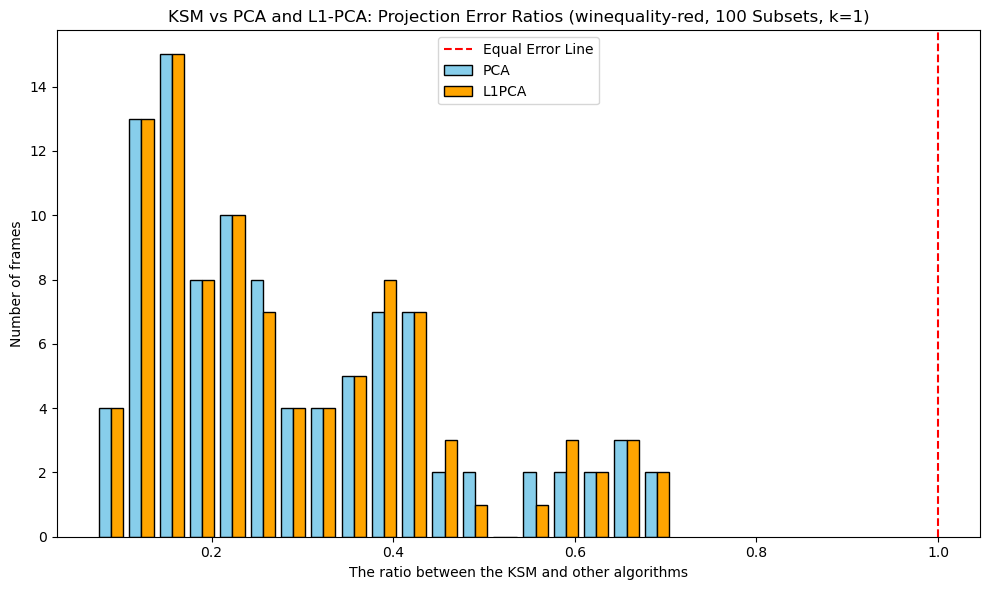


Comparison Statistics:


,Comparison,Percent better,Median ratio,Mean ratio,Worse cases (KSM > other),Max ratio (worst),Min ratio (best)
0,KSM vs PCA,100.0%,0.2373,0.2868,0,0.7070,0.0735
1,KSM vs L1PCA,100.0%,0.2377,0.2884,0,0.6986,0.0726



=== Analysis for k=2 components ===
Full dataset analysis (k=2):


,KSM Error (L2),PCA Error (L2),L1PCA Error (L2),KSM / PCA Ratio,KSM / L1PCA Ratio
0,1087.5500,3464.7036,3655.7763,0.3139,0.2975



Running 100 subset experiments...
Progress: 0/100
Progress: 20/100
Progress: 40/100
Progress: 60/100
Progress: 80/100


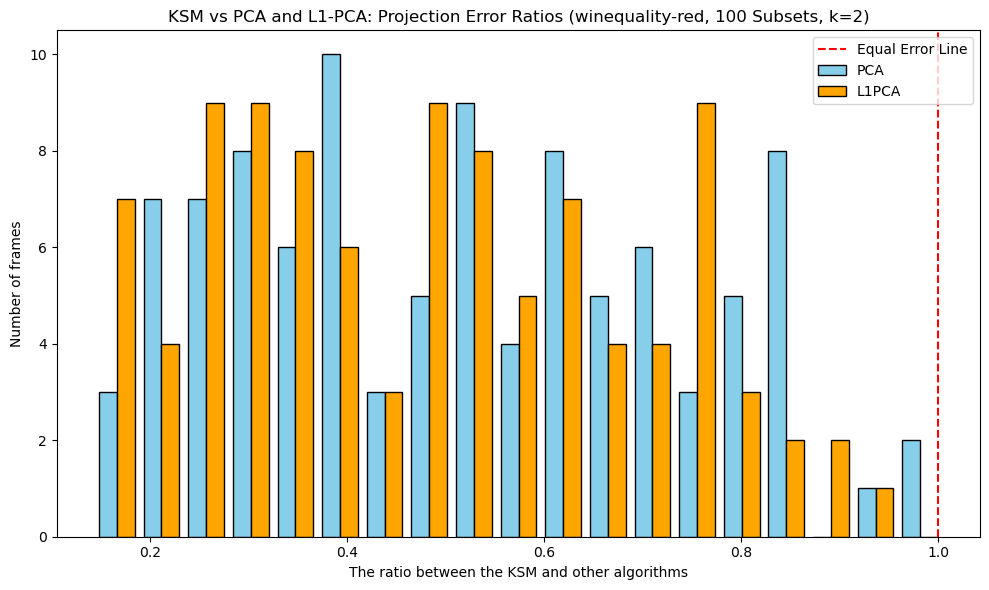


Comparison Statistics:


,Comparison,Percent better,Median ratio,Mean ratio,Worse cases (KSM > other),Max ratio (worst),Min ratio (best)
0,KSM vs PCA,99.0%,0.5193,0.5162,1,1.0041,0.1542
1,KSM vs L1PCA,100.0%,0.4764,0.4841,0,0.9506,0.1438


In [21]:
# Usage:
main(
    filepath="../wine+quality/winequality-red.csv",
    target_col="quality",
    sep=";",
    k_values=[1, 2]
)

##  Final Evaluation Summary

We evaluated the performance of KSM compared to PCA and L1PCA  
on the Wine Quality dataset (UCI), using projection error ratios across 100 random subsets.

The results are presented for two subspace dimensions:


####  For k = 1 (1D Subspace)

| Comparison     | Percent better | Median ratio | Mean ratio | Worse cases | Max ratio | Min ratio |
|----------------|----------------|---------------|-------------|--------------|------------|------------|
| KSM vs PCA     | 100.0%         | 0.2373        | 0.2868      | 0            | 0.7070     | 0.0735     |
| KSM vs L1PCA   | 100.0%         | 0.2377        | 0.2884      | 0            | 0.6986     | 0.0726     |

KSM consistently outperformed both PCA and L1PCA in all trials.  
Its mean error was **~71% lower than PCA**, and **~71% lower than L1PCA** on average.



#### For k = 2 (2D Subspace)

| Comparison     | Percent better | Median ratio | Mean ratio | Worse cases | Max ratio | Min ratio |
|----------------|----------------|---------------|-------------|--------------|------------|------------|
| KSM vs PCA     | 99.0%          | 0.5193        | 0.5162      | 1            | 1.0041     | 0.1542     |
| KSM vs L1PCA   | 100.0%         | 0.4764        | 0.4841      | 0            | 0.9506     | 0.1438     |

Even with higher `k`, KSM continued to outperform both baselines in nearly all cases.  
For `k = 2`, only one trial favored PCA — but KSM was still more robust overall.

---

These results highlight the **robustness and reliability** of KSM in both low and slightly higher subspace dimensions,  
even in the presence of noise and outliers.
